In [17]:
import pandas as pd
import numpy as np
import gdown
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import math
import time
import string
import random
import collections
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from tensorflow.keras import ops, backend
from tensorflow.keras.layers import Layer, EinsumDense, Softmax, Dropout
import keras
sns.set()

In [18]:
FILE_ID = "1hpsqSpfjdqIZWqwd259klQSeaNSe5Trr"
OUTPUT_CSV = "bitcoin3.csv"

gdown.download(f"https://drive.google.com/uc?id={FILE_ID}", output=OUTPUT_CSV, quiet=True)

# Baca file dengan pandas
df = pd.read_csv(OUTPUT_CSV)
df

,Date,Close,Volume USDT,RSI,MACD_Hist,ATR,KAMAO
0,2017-09-21 09:00:00.000,3860.00,7.443489e+04,49.192454,-48.279697,88.054720,2.495591
1,2017-09-21 10:00:00.000,3871.48,4.468732e+04,49.233202,-47.780476,87.996283,2.616710
2,2017-09-21 11:00:00.000,3864.95,8.054617e+04,49.210685,-47.308061,87.897128,2.532239
3,2017-09-21 12:00:00.000,3858.08,9.033153e+04,49.186948,-46.863233,87.720856,2.447245
4,2017-09-21 13:00:00.000,3856.67,1.034058e+05,49.182064,-46.425379,87.578086,2.424654
...,...,...,...,...,...,...,...
53145,2023-10-19 19:00:00,28750.75,2.984059e+07,53.630054,109.926882,129.065981,7.459700
53146,2023-10-19 20:00:00,28715.38,4.997623e+07,53.531282,111.721905,129.268969,7.118597
53147,2023-10-19 21:00:00,28604.09,3.205666e+07,53.221944,113.055031,129.287930,6.210037
53148,2023-10-19 22:00:00,28649.65,2.200420e+07,53.332673,114.513131,129.219782,6.515616


In [19]:
df["Date"] = pd.to_datetime(df["Date"], format="mixed")
df

,Date,Close,Volume USDT,RSI,MACD_Hist,ATR,KAMAO
0,2017-09-21 09:00:00,3860.00,7.443489e+04,49.192454,-48.279697,88.054720,2.495591
1,2017-09-21 10:00:00,3871.48,4.468732e+04,49.233202,-47.780476,87.996283,2.616710
2,2017-09-21 11:00:00,3864.95,8.054617e+04,49.210685,-47.308061,87.897128,2.532239
3,2017-09-21 12:00:00,3858.08,9.033153e+04,49.186948,-46.863233,87.720856,2.447245
4,2017-09-21 13:00:00,3856.67,1.034058e+05,49.182064,-46.425379,87.578086,2.424654
...,...,...,...,...,...,...,...
53145,2023-10-19 19:00:00,28750.75,2.984059e+07,53.630054,109.926882,129.065981,7.459700
53146,2023-10-19 20:00:00,28715.38,4.997623e+07,53.531282,111.721905,129.268969,7.118597
53147,2023-10-19 21:00:00,28604.09,3.205666e+07,53.221944,113.055031,129.287930,6.210037
53148,2023-10-19 22:00:00,28649.65,2.200420e+07,53.332673,114.513131,129.219782,6.515616


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53150 entries, 0 to 53149
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         53150 non-null  datetime64[ns]
 1   Close        53150 non-null  float64       
 2   Volume USDT  53150 non-null  float64       
 3   RSI          53150 non-null  float64       
 4   MACD_Hist    53150 non-null  float64       
 5   ATR          53150 non-null  float64       
 6   KAMAO        53150 non-null  float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 2.8 MB


In [21]:
df.describe()

,Date,Close,Volume USDT,RSI,MACD_Hist,ATR,KAMAO
count,53150,53150.000000,5.315000e+04,53150.000000,53150.000000,53150.000000,53150.000000
mean,2020-10-06 08:45:08.178286080,20595.357333,6.919215e+07,50.403605,0.528272,221.733334,0.229762
min,2017-09-21 09:00:00,3172.050000,0.000000e+00,35.178834,-1885.690630,17.436266,-31.767152
25%,2019-03-31 19:15:00,7976.915000,1.012558e+07,48.294197,-115.601600,72.702488,-2.717470
50%,2020-10-06 20:30:00,13878.095000,2.766119e+07,50.038483,10.154419,128.787616,-0.032747
75%,2022-04-14 05:45:00,29646.720000,8.944278e+07,52.406274,122.367509,325.616826,3.162442
max,2023-10-19 23:00:00,68633.690000,3.005634e+09,64.657108,1430.405758,1004.531407,39.740297
std,NaN,15822.296994,1.059041e+08,3.210682,353.293188,208.401440,5.168655


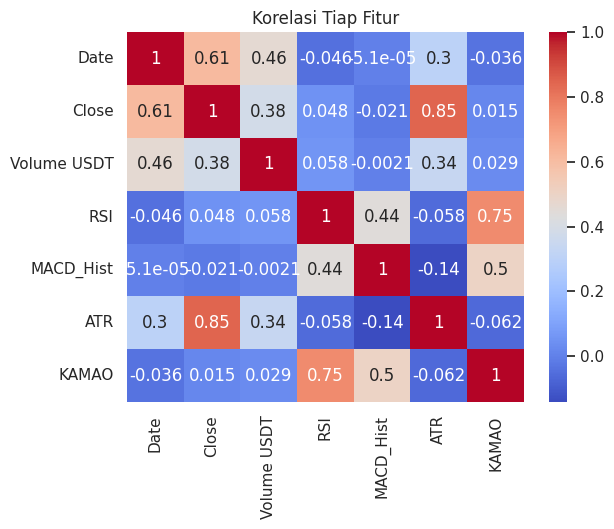

In [22]:
# Exploratory Data Analysis Menggunakan method .corr()
corr = df.corr()
sns.heatmap(corr, annot=True, cmap="coolwarm").set_title("Korelasi Tiap Fitur");

In [23]:
df = df.sort_values("Date").set_index("Date")
df

,Close,Volume USDT,RSI,MACD_Hist,ATR,KAMAO
Date,,,,,,
2017-09-21 09:00:00,3860.00,7.443489e+04,49.192454,-48.279697,88.054720,2.495591
2017-09-21 10:00:00,3871.48,4.468732e+04,49.233202,-47.780476,87.996283,2.616710
2017-09-21 11:00:00,3864.95,8.054617e+04,49.210685,-47.308061,87.897128,2.532239
2017-09-21 12:00:00,3858.08,9.033153e+04,49.186948,-46.863233,87.720856,2.447245
2017-09-21 13:00:00,3856.67,1.034058e+05,49.182064,-46.425379,87.578086,2.424654
...,...,...,...,...,...,...
2023-10-19 19:00:00,28750.75,2.984059e+07,53.630054,109.926882,129.065981,7.459700
2023-10-19 20:00:00,28715.38,4.997623e+07,53.531282,111.721905,129.268969,7.118597
2023-10-19 21:00:00,28604.09,3.205666e+07,53.221944,113.055031,129.287930,6.210037


### Mempersiapkan Data dan Membangun Model Baseline

In [24]:
SHORT_WINDOW = 7
LONG_WINDOW = 30

# Feature Engineering
df["rolling_mean"] = df["Close"].rolling(window=SHORT_WINDOW).mean()
df["rolling_std"] = df["Close"].rolling(window=SHORT_WINDOW).std()
df.fillna(0, inplace=True)
df

,Close,Volume USDT,RSI,MACD_Hist,ATR,KAMAO,rolling_mean,rolling_std
Date,,,,,,,,
2017-09-21 09:00:00,3860.00,7.443489e+04,49.192454,-48.279697,88.054720,2.495591,0.000000,0.000000
2017-09-21 10:00:00,3871.48,4.468732e+04,49.233202,-47.780476,87.996283,2.616710,0.000000,0.000000
2017-09-21 11:00:00,3864.95,8.054617e+04,49.210685,-47.308061,87.897128,2.532239,0.000000,0.000000
2017-09-21 12:00:00,3858.08,9.033153e+04,49.186948,-46.863233,87.720856,2.447245,0.000000,0.000000
2017-09-21 13:00:00,3856.67,1.034058e+05,49.182064,-46.425379,87.578086,2.424654,0.000000,0.000000
...,...,...,...,...,...,...,...,...
2023-10-19 19:00:00,28750.75,2.984059e+07,53.630054,109.926882,129.065981,7.459700,28629.658571,90.137546
2023-10-19 20:00:00,28715.38,4.997623e+07,53.531282,111.721905,129.268969,7.118597,28662.985714,66.514979
2023-10-19 21:00:00,28604.09,3.205666e+07,53.221944,113.055031,129.287930,6.210037,28652.077143,69.373602


In [25]:
feature_to_use = ["Close", "rolling_mean", "rolling_std"]
df = df[feature_to_use]

In [26]:
# Splitting data train 80%, data val 10%, data test 10%
n_data = len(df)

train_split = int(n_data * 0.8)
val_split = int(n_data * 0.9)

train_data = df.iloc[:train_split]
val_data = df.iloc[train_split:val_split]
test_data = df.iloc[val_split:]

print(f"train_data : {train_data.shape}")
print(f"val_data : {val_data.shape}")
print(f"test_data : {test_data.shape}")

train_data : (42520, 3)
val_data : (5315, 3)
test_data : (5315, 3)


In [27]:
# Normalisasi
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_data)
val_scaled = scaler.transform(val_data)
test_scaled = scaler.transform(test_data)

In [28]:
def make_multivariate_window(window, horizon):
    encoder_input = window[:-horizon]
    decoder_target = window[-horizon:, 0:1]
    start_token = encoder_input[-1:, 0:1]
    decoder_input = tf.concat([start_token, decoder_target[:-1]], axis=0)

    return (encoder_input, decoder_input), decoder_target

In [29]:
def create_multivariate_dataset(series, window_size, horizon, batch_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + horizon, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + horizon))
    ds = ds.map(lambda w: make_multivariate_window(w, horizon))

    return ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [30]:
# Tentukan parameter model
WINDOW_SIZE = 300
HORIZON = 24
BATCH_SIZE = 32

# Buat pipeline data
train_ds_multi = create_multivariate_dataset(train_scaled, WINDOW_SIZE, HORIZON, BATCH_SIZE)
val_ds_multi = create_multivariate_dataset(val_scaled, WINDOW_SIZE, HORIZON, BATCH_SIZE)
test_ds_multi = create_multivariate_dataset(test_scaled, WINDOW_SIZE, HORIZON, BATCH_SIZE)
train_ds_multi

<_PrefetchDataset element_spec=((TensorSpec(shape=(None, None, 3), dtype=tf.float64, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None)), TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None))>

In [31]:
df

,Close,rolling_mean,rolling_std
Date,,,
2017-09-21 09:00:00,3860.00,0.000000,0.000000
2017-09-21 10:00:00,3871.48,0.000000,0.000000
2017-09-21 11:00:00,3864.95,0.000000,0.000000
2017-09-21 12:00:00,3858.08,0.000000,0.000000
2017-09-21 13:00:00,3856.67,0.000000,0.000000
...,...,...,...
2023-10-19 19:00:00,28750.75,28629.658571,90.137546
2023-10-19 20:00:00,28715.38,28662.985714,66.514979
2023-10-19 21:00:00,28604.09,28652.077143,69.373602


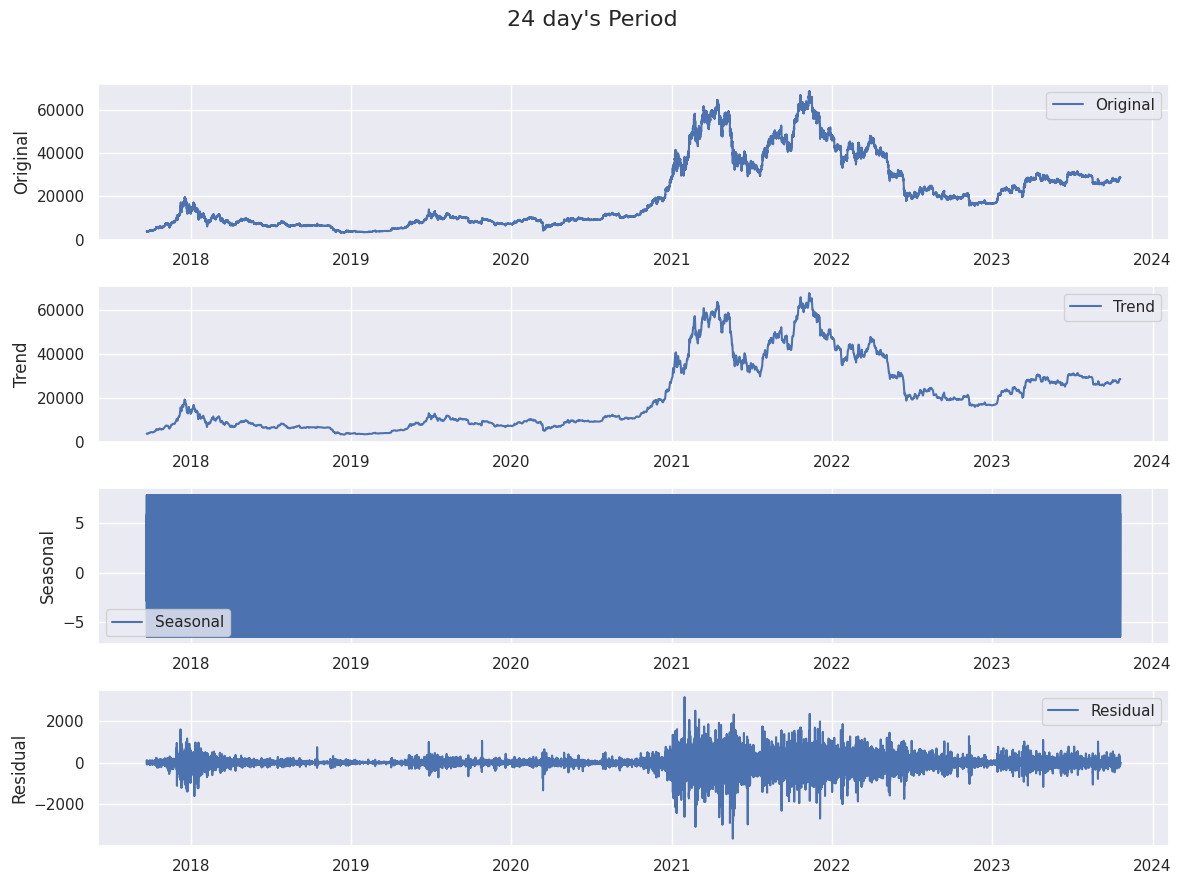

In [32]:
# Visualisasi dekomposisi time series seperti trend, musiman, dan residual
decomposition = seasonal_decompose(df['Close'], period=HORIZON, model='additive')
 
components = {
    'Original': df['Close'],
    'Trend': decomposition.trend,
    'Seasonal': decomposition.seasonal,
    'Residual': decomposition.resid
}
 
plt.figure(figsize=(12, 9))
plt.suptitle(f"{HORIZON} day's Period", fontsize=16)
 
for i, (title, series) in enumerate(components.items(), start=1):
    plt.subplot(4, 1, i)
    plt.plot(df.index, series, label=title)
    plt.legend(loc='best')
    plt.ylabel(title)
 
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

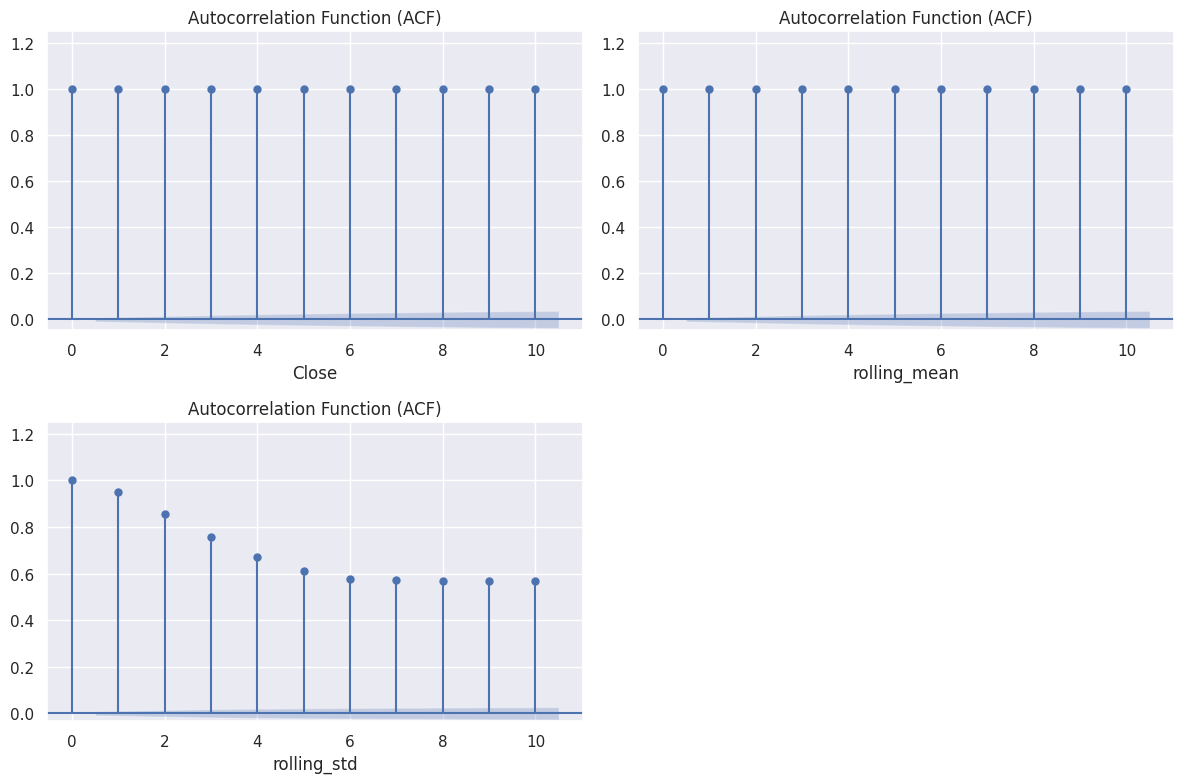

In [115]:
# Visualisasi dekomposisi data ACF
plt.figure(figsize=(12, 8))
for i, feature in enumerate(feature_to_use):
    plt.subplot(2, 2, i + 1)
    plot_acf(df[feature], lags=10, ax=plt.gca(), auto_ylims=True)
    plt.title("Autocorrelation Function (ACF)")
    plt.xlabel(feature)

plt.tight_layout()
plt.show()

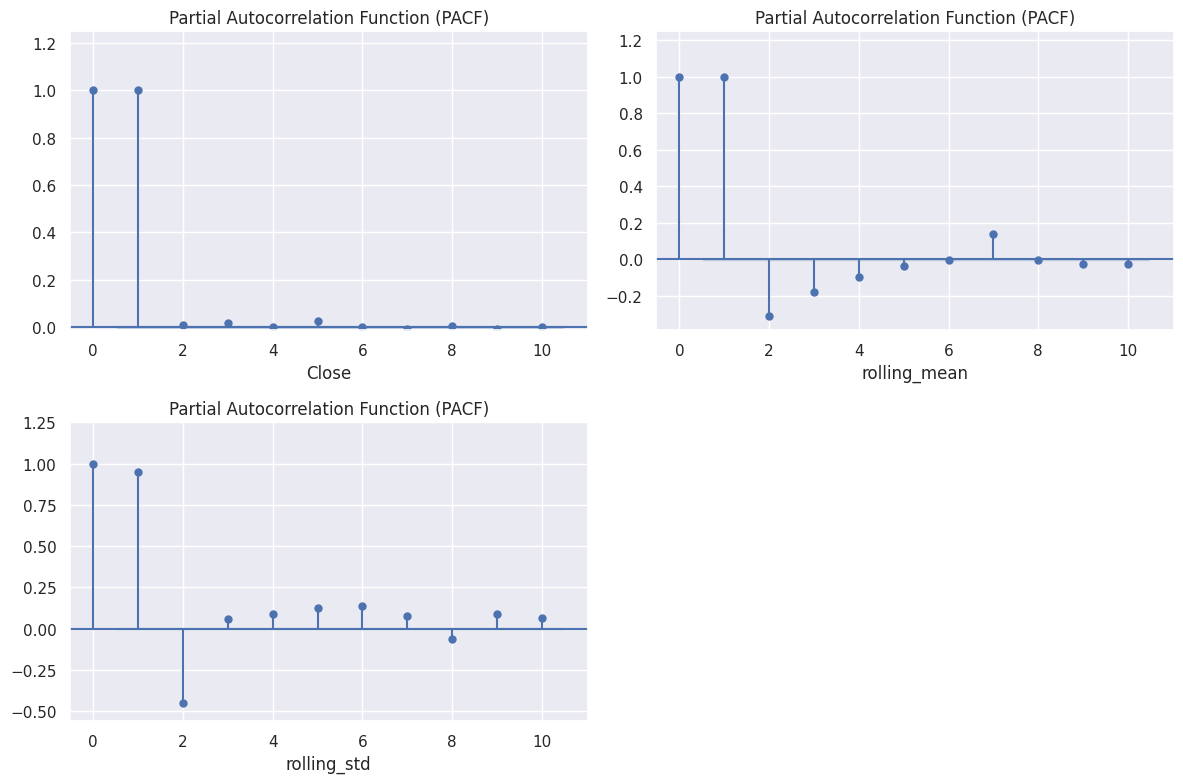

In [116]:
# Visualisasi dekomposisi data PACF
plt.figure(figsize=(12, 8))
for i, feature in enumerate(feature_to_use):
    plt.subplot(2, 2, i + 1)
    plot_pacf(df[feature], lags=10, ax=plt.gca(), auto_ylims=True)
    plt.title("Partial Autocorrelation Function (PACF)")
    plt.xlabel(feature)

plt.tight_layout()
plt.show()

### Membangun Arsitektur Model Kustom

In [117]:
class MyDense(tf.keras.layers.Layer):
    def __init__(self, units=32, activation="relu"):
        super(MyDense, self).__init__()
        self.units = units
        self.activation = tf.keras.activations.get(activation)

    def build(self, input_shape):
        w_init = tf.random_normal_initializer()
        self.w = tf.Variable(name="kernel",
                             initial_value=w_init(shape=(input_shape[1], self.units), dtype="float32"),
                             trainable=True)
        b_init = tf.zeros_initializer()
        self.b = tf.Variable(name="bias",
                             initial_value=b_init(shape=(self.units), dtype="float32"),
                             trainable=True)
    def call(self, inputs):
        return self.activation(tf.matmul(inputs, self.w) + self.b)

    def get_config(self):
        base_config = super().get_config()
        config = {
            "units": self.units,
            "activation": self.activation
        }
        return {**base_config, **config}        

In [118]:
class MyDropout(tf.keras.layers.Layer):
    """
        Rererensi:
        https://github.com/keras-team/keras/blob/v3.11.3/keras/src/layers/regularization/dropout.py#L6
    """
    
    def __init__(self, rate, **kwargs):
        super().__init__(**kwargs)
        if not 0 <= rate <= 1:
            raise ValueError(
                f"Invalid value received for argument "
                "`rate`. Expected a float value between 0 and 1. "
                f"Received: rate={rate}"
            )
        self.rate = rate

    def call(self, inputs, training=False):
        if training:
            return tf.nn.dropout(inputs, rate=self.rate)
        else:
            return inputs

    def compute_output_shape(self, input_shape):
        return input_shape

    def get_config(self):
        base_config = super().get_config()
        config = {
            "rate": self.rate,
        }
        return {**base_config, **config}

In [119]:
def _index_to_einsum_variable(i):
    return string.ascii_lowercase[i]

def _build_attention_equation(rank, attn_axes):
    target_notation = ""
    for i in range(rank):
        target_notation += _index_to_einsum_variable(i)
    batch_dims = tuple(np.delete(range(rank), attn_axes + (rank - 1,)))
    letter_offset = rank
    source_notation = ""
    for i in range(rank):
        if i in batch_dims or i == rank - 1:
            source_notation += target_notation[i]
        else:
            source_notation += _index_to_einsum_variable(letter_offset)
            letter_offset += 1
    product_notation = "".join(
        [target_notation[i] for i in batch_dims]
        + [target_notation[i] for i in attn_axes]
        + [source_notation[i] for i in attn_axes]
    )
    dot_product_equation = "%s,%s->%s" % (source_notation, target_notation, product_notation)
    attn_scores_rank = len(product_notation)
    combine_equation = "%s,%s->%s" % (product_notation, source_notation, target_notation)
    return dot_product_equation, combine_equation, attn_scores_rank

def _build_proj_equation(free_dims, bound_dims, output_dims):
    input_str, kernel_str, output_str, bias_axes = "", "", "", ""
    letter_offset = 0
    for i in range(free_dims):
        char = _index_to_einsum_variable(i + letter_offset)
        input_str += char
        output_str += char
    letter_offset += free_dims
    for i in range(bound_dims):
        char = _index_to_einsum_variable(i + letter_offset)
        input_str += char
        kernel_str += char
    letter_offset += bound_dims
    for i in range(output_dims):
        char = _index_to_einsum_variable(i + letter_offset)
        kernel_str += char
        output_str += char
        bias_axes += char
    equation = f"{input_str},{kernel_str}->{output_str}"
    return equation, bias_axes, len(output_str)

def _get_output_shape(output_rank, known_last_dims):
    return [None] * (output_rank - len(known_last_dims)) + list(known_last_dims)


class MyMultiHeadAttention(Layer):
    """
    Referensi:
    https://github.com/keras-team/keras/blob/v3.3.3/keras/src/layers/attention/multi_head_attention.py#L19-L636
    """
    def __init__(self, num_heads, key_dim, value_dim=None, dropout=0.0, output_shape=None, attention_axes=None, **kwargs):
        super().__init__(**kwargs)
        self.supports_masking = True
        self._num_heads = num_heads
        self._key_dim = key_dim
        self._value_dim = value_dim if value_dim is not None else key_dim
        self._attention_axes = attention_axes
        self._dropout = dropout
        self._output_shape = output_shape
        
    @property
    def num_heads(self):
        return self._num_heads

    @property
    def key_dim(self):
        return self._key_dim
    
    @property
    def dropout(self):
        return self._dropout

    def build(self, query_shape, value_shape, key_shape=None):
        if key_shape is None:
            key_shape = value_shape
        query_rank = len(query_shape)
        value_rank = len(value_shape)
        key_rank = len(key_shape)
        
        einsum_equation, _, output_rank = _build_proj_equation(query_rank - 1, bound_dims=1, output_dims=2)
        self._query_dense = EinsumDense(
            einsum_equation,
            output_shape=_get_output_shape(output_rank - 1, [self._num_heads, self._key_dim]),
            name="query"
        )
        self._query_dense.build(query_shape)

        einsum_equation, _, output_rank = _build_proj_equation(key_rank - 1, bound_dims=1, output_dims=2)
        self._key_dense = EinsumDense(
            einsum_equation,
            output_shape=_get_output_shape(output_rank - 1, [self._num_heads, self._key_dim]),
            name="key"
        )
        self._key_dense.build(key_shape)

        einsum_equation, _, output_rank = _build_proj_equation(value_rank - 1, bound_dims=1, output_dims=2)
        self._value_dense = EinsumDense(
            einsum_equation,
            output_shape=_get_output_shape(output_rank - 1, [self._num_heads, self._value_dim]),
            name="value"
        )
        self._value_dense.build(value_shape)

        self._build_attention(output_rank)
        
        self._output_dense = self._make_output_dense(query_shape, "attention_output")
        output_dense_input_shape = list(self._query_dense.compute_output_shape(query_shape))
        output_dense_input_shape[-1] = self._value_dim
        self._output_dense.build(tuple(output_dense_input_shape))
        
        self.built = True

    def _make_output_dense(self, query_shape, name):
        query_rank = len(query_shape)
        # Sekarang self._output_shape dijamin ada
        if self._output_shape:
            if not isinstance(self._output_shape, collections.abc.Sized):
                output_shape = [self._output_shape]
            else:
                output_shape = self._output_shape
        else:
            output_shape = [query_shape[-1]]
        
        einsum_equation, _, output_rank = _build_proj_equation(query_rank - 1, bound_dims=2, output_dims=len(output_shape))
        return EinsumDense(
            einsum_equation,
            output_shape=_get_output_shape(output_rank - 1, output_shape),
            name=name
        )

    def _build_attention(self, rank):
        if self._attention_axes is None:
            self._attention_axes = tuple(range(1, rank - 2))
        else:
            self._attention_axes = tuple(self._attention_axes)
        
        (
            self._dot_product_equation,
            self._combine_equation,
            attn_scores_rank,
        ) = _build_attention_equation(rank, attn_axes=self._attention_axes)
        
        norm_axes = tuple(range(attn_scores_rank - len(self._attention_axes), attn_scores_rank))
        self._softmax = Softmax(axis=norm_axes)
        self._dropout_layer = Dropout(rate=self._dropout)
        self._inverse_sqrt_key_dim = 1.0 / math.sqrt(float(self._key_dim))

    def _masked_softmax(self, attention_scores, attention_mask=None):
        if attention_mask is not None:
            mask_expansion_axis = -len(self._attention_axes) * 2 - 1
            for _ in range(len(attention_scores.shape) - len(attention_mask.shape)):
                attention_mask = ops.expand_dims(attention_mask, axis=mask_expansion_axis)
        return self._softmax(attention_scores, mask=attention_mask)

    def _compute_attention(self, query, key, value, attention_mask=None, training=None):
        query = ops.multiply(query, ops.cast(self._inverse_sqrt_key_dim, query.dtype))
        attention_scores = ops.einsum(self._dot_product_equation, key, query)
        attention_scores = self._masked_softmax(attention_scores, attention_mask)

        if self.dropout > 0.0:
            final_attn_scores = self._dropout_layer(attention_scores, training=training)
        else:
            final_attn_scores = attention_scores

        attention_output = ops.einsum(self._combine_equation, final_attn_scores, value)
        return attention_output, attention_scores

    def call(self, query, value, key=None, return_attention_scores=False, training=None, use_causal_mask=False):
        if key is None:
            key = value
            
        attention_mask = self._compute_attention_mask(query, value, use_causal_mask=use_causal_mask)

        query = self._query_dense(query)
        key = self._key_dense(key)
        value = self._value_dense(value)

        attention_output, attention_scores = self._compute_attention(query, key, value, attention_mask, training)
        attention_output = self._output_dense(attention_output)

        if return_attention_scores:
            return attention_output, attention_scores
        return attention_output

    def _compute_attention_mask(self, query, value, use_causal_mask=False):
        if use_causal_mask:
            return self._compute_causal_mask(query, value)
        return None

    def _compute_causal_mask(self, query, value):
        q_seq_length = ops.shape(query)[1]
        v_seq_length = ops.shape(value)[1]
        ones_mask = ops.ones((1, q_seq_length, v_seq_length), dtype="int32")
        row_index = ops.cumsum(ones_mask, axis=-2)
        col_index = ops.cumsum(ones_mask, axis=-1)
        return ops.greater_equal(row_index, col_index)

    def compute_output_shape(self, query_shape, value_shape, key_shape=None):
        if key_shape is None:
            key_shape = value_shape

        if query_shape[-1] != value_shape[-1]:
            raise ValueError(
                "The last dimension of `query_shape` and `value_shape` "
                f"must be equal, but are {query_shape[-1]}, {value_shape[-1]}. "
                "Received: query_shape={query_shape}, value_shape={value_shape}"
            )

        if value_shape[1:-1] != key_shape[1:-1]:
            raise ValueError(
                "All dimensions of `value` and `key`, except the last one, "
                f"must be equal. Received: value_shape={value_shape} and "
                f"key_shape={key_shape}"
            )

        if self._output_shape:
            return query_shape[:-1] + self._output_shape

        return query_shape

    def get_config(self):
        base_config = super().get_config()
        config = {
            "num_heads": self._num_heads,
            "key_dim": self._key_dim,
            "value_dim": self._value_dim,
            "dropout": self._dropout,
            "output_shape": self._output_shape,
            "attention_axes": self._attention_axes,
        }
        return {**base_config, **config}

In [120]:
NUM_FEATURES = 3

# Membangun model LSTM dasar sebagai baseline
model_lstm_baseline = tf.keras.Sequential([
    tf.keras.layers.LSTM(128, input_shape=(WINDOW_SIZE, NUM_FEATURES), return_sequences=True),
    tf.keras.layers.LSTM(64, return_sequences=False),
    tf.keras.layers.Dense(HORIZON)
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [121]:
model_lstm_baseline.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 300, 128)       │        67,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 24)             │         1,560 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 118,552 (463.09 KB)

 Trainable params: 118,552 (463.09 KB)

 Non-trainable params: 0 (0.00 B)

In [122]:
model_lstm_baseline.compile(
    loss="mae",
    metrics=["mae"],
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3)
)
 
history_lstm_baseline = model_lstm_baseline.fit(
    train_ds_multi,
    epochs=20,
    validation_data=val_ds_multi
)

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_4
Received: inputs=('Tensor(shape=(None, None, 3))', 'Tensor(shape=(None, None, 1))')
  warnings.warn(msg)


   1319/Unknown 38s 27ms/step - loss: 0.0152 - mae: 0.0152

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1319/1319 ━━━━━━━━━━━━━━━━━━━━ 41s 29ms/step - loss: 0.0152 - mae: 0.0152 - val_loss: 0.0441 - val_mae: 0.0441
Epoch 2/20
1319/1319 ━━━━━━━━━━━━━━━━━━━━ 38s 29ms/step - loss: 0.0358 - mae: 0.0358 - val_loss: 0.0450 - val_mae: 0.0450
Epoch 3/20
1319/1319 ━━━━━━━━━━━━━━━━━━━━ 38s 28ms/step - loss: 0.0319 - mae: 0.0319 - val_loss: 0.0483 - val_mae: 0.0483
Epoch 4/20
1319/1319 ━━━━━━━━━━━━━━━━━━━━ 38s 29ms/step - loss: 0.0284 - mae: 0.0284 - val_loss: 0.0418 - val_mae: 0.0418
Epoch 5/20
1319/1319 ━━━━━━━━━━━━━━━━━━━━ 38s 29ms/step - loss: 0.0241 - mae: 0.0241 - val_loss: 0.0356 - val_mae: 0.0356
Epoch 6/20
1319/1319 ━━━━━━━━━━━━━━━━━━━━ 38s 29ms/step - loss: 0.0210 - mae: 0.0210 - val_loss: 0.0328 - val_mae: 0.0328
Epoch 7/20
1319/1319 ━━━━━━━━━━━━━━━━━━━━ 38s 29ms/step - loss: 0.0194 - mae: 0.0194 - val_loss: 0.0316 - val_mae: 0.0316
Epoch 8/20
1319/1319 ━━━━━━━━━━━━━━━━━━━━ 38s 29ms/step - loss: 0.0181 - mae: 0.0181 - val_loss: 0.0299 - val_mae: 0.0299
Epoch 9/20
1319/1319 ━━━━━━━━━━━━━━

In [123]:
min_price_feature = scaler.data_min_[0]
max_price_feature = scaler.data_max_[0]
print(f"Min value : {min_price_feature}, Max value : {max_price_feature}")

Min value : 3172.05, Max value : 68633.69


In [149]:
# Denormalisasi data prediksi
predicted_price_scaled = model_lstm_baseline.predict(test_ds_multi)
predicted_price_baseline_lstm = predicted_price_scaled * (max_price_feature - min_price_feature) + min_price_feature
predicted_price_baseline_lstm

156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


array([[27244.041, 27204.37 , 27219.168, ..., 26963.729, 26707.68 ,
        26648.734],
       [27226.686, 27190.412, 27203.418, ..., 26946.707, 26720.604,
        26659.664],
       [27134.078, 27105.166, 27109.562, ..., 26866.014, 26668.838,
        26613.113],
       ...,
       [27975.355, 27928.543, 27943.807, ..., 27639.96 , 27407.564,
        27371.363],
       [28017.799, 27968.205, 27986.633, ..., 27675.572, 27437.857,
        27400.955],
       [28061.018, 28009.592, 28029.963, ..., 27713.166, 27474.137,
        27437.06 ]], dtype=float32)

In [150]:
# Ambil data target price dengan horizon
predicted_price_baseline_lstm = predicted_price_baseline_lstm[0, :]
predicted_price_baseline_lstm

array([27244.041, 27204.37 , 27219.168, 27020.812, 27080.26 , 27107.137,
       27086.41 , 27036.23 , 26916.46 , 27110.814, 27327.602, 27304.572,
       26784.736, 26946.85 , 26609.566, 26825.732, 26734.594, 27074.918,
       27105.574, 26831.447, 27025.332, 26963.729, 26707.68 , 26648.734],
      dtype=float32)

In [151]:
test_data

,Close,rolling_mean,rolling_std
Date,,,
2023-03-12 11:00:00,20445.43,20380.515714,41.784849
2023-03-12 12:00:00,20381.25,20384.311429,40.224463
2023-03-12 13:00:00,20383.95,20391.761429,33.071154
2023-03-12 14:00:00,20339.55,20390.738571,34.764172
2023-03-12 15:00:00,20358.96,20388.178571,36.567810
...,...,...,...
2023-10-19 19:00:00,28750.75,28629.658571,90.137546
2023-10-19 20:00:00,28715.38,28662.985714,66.514979
2023-10-19 21:00:00,28604.09,28652.077143,69.373602


In [152]:
for (encoder_in, decoder_in), decoder_target in test_ds_multi.take(11):
    sample_encoder_input = encoder_in[0:1] # Ambil 1 sampel, shape: (1, 300, 3)
    sample_decoder_target = decoder_target[0] # Target sebenarnya, shape: (24, 1)
sample_decoder_target

<tf.Tensor: shape=(24, 1), dtype=float64, numpy=
array([[0.3764756 ],
       [0.37728095],
       [0.37825679],
       [0.37684436],
       [0.3776346 ],
       [0.37770028],
       [0.37797082],
       [0.37842086],
       [0.37743097],
       [0.37792301],
       [0.37762146],
       [0.3777093 ],
       [0.3772003 ],
       [0.37761168],
       [0.37860249],
       [0.37784388],
       [0.37744578],
       [0.37779668],
       [0.37861425],
       [0.3796321 ],
       [0.37904535],
       [0.3814275 ],
       [0.38100283],
       [0.3805919 ]])>

In [153]:
# Denormalisasi data aktual
actual_price = sample_decoder_target * (max_price_feature - min_price_feature) + min_price_feature
actual_price = actual_price.numpy()[:, 0]
actual_price

array([27816.76, 27869.48, 27933.36, 27840.9 , 27892.63, 27896.93,
       27914.64, 27944.1 , 27879.3 , 27911.51, 27891.77, 27897.52,
       27864.2 , 27891.13, 27955.99, 27906.33, 27880.27, 27903.24,
       27956.76, 28023.39, 27984.98, 28140.92, 28113.12, 28086.22])

In [154]:
# Inference menggunakan model baseline LSTM
pd.DataFrame({
    "Jam Ke": df.index.hour[:HORIZON],
    "Data Aktual": actual_price,
    "Hasil Prediksi Baseline LSTM": predicted_price_baseline_lstm,
    "Selisih": actual_price - predicted_price_baseline_lstm
})

,Jam Ke,Data Aktual,Hasil Prediksi Baseline LSTM,Selisih
0,9,27816.76,27244.041016,572.718984
1,10,27869.48,27204.369141,665.110859
2,11,27933.36,27219.167969,714.192031
3,12,27840.90,27020.812500,820.087500
4,13,27892.63,27080.259766,812.370234
5,14,27896.93,27107.136719,789.793281
6,15,27914.64,27086.410156,828.229844
7,16,27944.10,27036.230469,907.869531
8,17,27879.30,26916.460938,962.839062
9,18,27911.51,27110.814453,800.695547


In [172]:
loss = model_lstm_baseline.evaluate(test_ds_multi)[0]
print(f"Loss : {loss}")

156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0104 - mae: 0.0104
Loss : 0.009503547102212906


In [131]:
model_lstm_baseline.save("model_baseline_LSTM.keras")

In [133]:
# Seq2Seq LSTM dengan pendekatan Teacher Forcing menggunakan model subclassing
class MySeq2SeqAttention(tf.keras.Model):
    def __init__(self, lstm_units, num_heads, dropout_rate=0.0, name="seq2seq_attention", **kwargs):
        super().__init__(name=name, **kwargs)
        self.lstm_units = lstm_units
        self.num_heads = num_heads
        self.dropout_rate = dropout_rate
        
        self.encoder_lstm = tf.keras.layers.LSTM(
            self.lstm_units, 
            return_sequences=True, 
            return_state=True, 
            name="encoder_lstm"
        )
        
        self.decoder_lstm = tf.keras.layers.LSTM(
            self.lstm_units, 
            return_sequences=True, 
            return_state=True, 
            name="decoder_lstm"
        )
        self.decoder_dropout = MyDropout(dropout_rate, name="decoder_dropout")
        self.attention_layer = MyMultiHeadAttention(
            num_heads=self.num_heads, 
            key_dim=self.lstm_units, 
            name="multi_head_attention"
        )
        
        self.vector_dropout = MyDropout(self.dropout_rate, name="vector_dropout")
        self.concat_layer = tf.keras.layers.Concatenate(axis=-1, name="concatenate_layer")
        self.output_layer = tf.keras.layers.TimeDistributed(
            tf.keras.layers.Dense(1), name="output_layer"
        )

    def call(self, inputs, training=False):
        encoder_input, decoder_input = inputs
        
        encoder_outputs, state_h, state_c = self.encoder_lstm(encoder_input, training=training)
        encoder_states = [state_h, state_c]
        
        decoder_outputs, state_h_dec, state_c_dec = self.decoder_lstm(decoder_input, initial_state=encoder_states, training=training)
        decoder_dropout_output = self.decoder_dropout(decoder_outputs, training=training)
        
        context_vector = self.attention_layer(
            query=decoder_dropout_output, 
            value=encoder_outputs, 
            key=encoder_outputs,
            training=training
        )
        
        vector_dropout_output = self.vector_dropout(context_vector, training=training)
        decoder_combined_output = self.concat_layer([decoder_dropout_output, vector_dropout_output])
        output = self.output_layer(decoder_combined_output, training=training)
        
        return output

    def get_config(self):
        base_config = super().get_config()
        config = {
            "lstm_units": self.lstm_units,
            "num_heads": self.num_heads,
            "dropout_rate": self.dropout_rate,
        }
        return {**base_config, **config}

    @classmethod
    def from_config(cls, config):
        return cls(**config)

In [134]:
LSTM_UNITS = 64
NUM_HEADS = 4
DROPOUT_RATE = 0.4

model_attention_subclassed = MySeq2SeqAttention(
    lstm_units=LSTM_UNITS,
    num_heads=NUM_HEADS,
    dropout_rate=DROPOUT_RATE
)

dummy_encoder_input = tf.random.uniform(shape=(1, WINDOW_SIZE, 3))
dummy_decoder_input = tf.random.uniform(shape=(1, HORIZON, 1))

_ = model_attention_subclassed([dummy_encoder_input, dummy_decoder_input])
model_attention_subclassed.summary()

Model: "seq2seq_attention"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_lstm (LSTM)             │ ((1, 300, 64), (1,     │        17,408 │
│                                 │ 64), (1, 64))          │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_lstm (LSTM)             │ ((1, 24, 64), (1, 64), │        16,896 │
│                                 │ (1, 64))               │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_dropout (MyDropout)     │ (1, 24, 64)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ multi_head_attention            │ (1, 24, 64)            │        65,536 │
│ (MyMultiHeadAttention)          │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vector_dropout (MyDropout)      │ (1, 24, 64)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ concatenate_layer (Concatenate) │ (1, 24, 128)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (TimeDistributed)  │ (1, 24, 1)             │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 99,969 (390.50 KB)

 Trainable params: 99,969 (390.50 KB)

 Non-trainable params: 0 (0.00 B)

In [137]:
class MyMAE(tf.keras.losses.Loss):
  def __init__(self, weights):
    super().__init__()
    self.weights = tf.constant(weights, dtype=tf.float32)
    
  def call(self, y_true, y_pred):
    mae_error = tf.math.abs(y_true - y_pred)
    weighted_mae_differece = mae_error * self.weights
      
    return tf.reduce_mean(weighted_mae_differece, axis=-1)

In [138]:
class MyEarlyStopping(tf.keras.callbacks.Callback):
    """
        Referensi:
        https://github.com/keras-team/keras/blob/v3.3.3/keras/src/callbacks/early_stopping.py#L10-L213
    """
    
    def __init__(self, monitor='val_loss', patience=3, mode='min', restore_best_weights=True):
        super(MyEarlyStopping, self).__init__()
        self.monitor = monitor
        self.patience = patience
        self.restore_best_weights = restore_best_weights

        if mode == 'auto':
            if 'acc' in self.monitor:
                self.mode = 'max'
            else:
                self.mode = 'min'
        else:
            self.mode = mode

        if self.mode == 'min':
            self.monitor_op = np.less
            self.best_value = np.Inf
        elif self.mode == 'max':
            self.monitor_op = np.greater
            self.best_value = -np.Inf
        else:
            raise ValueError(f"Mode '{self.mode}' tidak dikenali. Gunakan 'min', 'max', atau 'auto'.")

    def on_train_begin(self, logs=None):
        self.wait_count = 0
        self.stopped_epoch = 0
        self.best_weights = None
        self.best_value = np.Inf if self.mode == 'min' else -np.Inf

    def on_epoch_end(self, epoch, logs=None):
        current_value = logs.get('val_loss') if logs else None

        if current_value is None:
            print(f"Metrik Early Stopping '{self.monitor}' tidak tersedia. Training akan dilanjutkan.")
            return

        if self.monitor_op(current_value, self.best_value):
            self.best_value = current_value
            self.wait_count = 0
            if self.restore_best_weights:
                self.best_weights = self.model.get_weights()
        else:
            self.wait_count += 1

        if self.wait_count >= self.patience:
            self.stopped_epoch = epoch
            self.model.stop_training = True
            print(f"\nEpoch {epoch + 1}: Early stopping karena '{self.monitor}' tidak membaik selama {self.patience} epoch.")

    def on_train_end(self, logs=None):
        if self.stopped_epoch > 0 and self.restore_best_weights:
            print(f"Mengembalikan bobot model dari akhir epoch terbaik: {self.stopped_epoch - self.patience + 1}")
            self.model.set_weights(self.best_weights)

In [139]:
class MyLearningRateScheduler(tf.keras.callbacks.Callback):
    def __init__(self, optimizer, decay_factor=0.5, patience=1):
        super(MyLearningRateScheduler, self).__init__()
        self.optimizer = optimizer
        self.decay_factor = decay_factor
        self.patience = patience
        self.best_val_loss = float('inf')
        self.wait = 0

    def on_epoch_end(self, epoch, logs=None):
        current_val_loss = logs.get('val_loss') if logs else None
        
        if current_val_loss is None:
            return

        if current_val_loss < self.best_val_loss:
            self.best_val_loss = current_val_loss
            self.wait = 0
            print(f"Epoch {epoch + 1}: val_loss membaik ke {current_val_loss:.4f}")
        else:
            self.wait += 1
            print(f"Epoch {epoch + 1}: val_loss tidak membaik ({self.wait}/{self.patience})")

        if self.wait >= self.patience:
            old_lr = self.optimizer.learning_rate.numpy()
            new_lr = max(old_lr * self.decay_factor, 1e-6) # batas bawah biar gak 0
            self.optimizer.learning_rate.assign(new_lr)
            self.wait = 0
            print(f"Learning rate diturunkan dari {old_lr:.6f} ke {new_lr:.6f}")


### Membuat Pelatihan Kustom

In [140]:
weights_list = []

for i in range(1, HORIZON):
    if len(weights_list) == 0:
        weights_list.append(i)
    else:
        weights_list.append(np.round(weights_list[-1] + 0.2, 2))

print(weights_list)

[1, 1.2, 1.4, 1.6, 1.8, 2.0, 2.2, 2.4, 2.6, 2.8, 3.0, 3.2, 3.4, 3.6, 3.8, 4.0, 4.2, 4.4, 4.6, 4.8, 5.0, 5.2, 5.4]


In [141]:
class MyTrainer: 
    def __init__(self, model, loss_fn, optimizer, callbacks=[], checkpoint_dir="./checkpoints"):
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.callbacks = callbacks
        self.best_val_loss = float('inf')
        self.checkpoint_dir = checkpoint_dir
        
        self.train_loss_metric = tf.keras.metrics.Mean(name='train_loss')
        self.val_loss_metric = tf.keras.metrics.Mean(name='val_loss')

        self.checkpoint = tf.train.Checkpoint(optimizer=self.optimizer, model=self.model)
        self.checkpoint_manager = tf.train.CheckpointManager(self.checkpoint, self.checkpoint_dir, max_to_keep=3)

    @tf.function
    def train_step(self, x_batch, y_batch):
        encoder_input, decoder_input = x_batch
        
        with tf.GradientTape() as tape:
            predictions = self.model((encoder_input, decoder_input), training=True)
            loss = self.loss_fn(y_batch, predictions)
        
        gradients = tape.gradient(loss, self.model.trainable_variables)
        clipped_grads = [tf.clip_by_value(g, -1.0, 1.0) for g in gradients]
        self.optimizer.apply_gradients(zip(clipped_grads, self.model.trainable_variables))
        
        self.train_loss_metric.update_state(loss)

    @tf.function
    def val_step(self, x_batch, y_batch):
        encoder_input, decoder_input = x_batch
        
        predictions = self.model((encoder_input, decoder_input), training=False)
        loss = self.loss_fn(y_batch, predictions)
        
        self.val_loss_metric.update_state(loss)

    def evaluate(self, test_dataset):
        self.val_loss_metric.reset_state()
        
        for x_batch, y_batch in test_dataset:
            self.val_step(x_batch, y_batch)
            
        test_loss = self.val_loss_metric.result()
        return {'loss': test_loss.numpy()}

    def fit(self, train_dataset, val_dataset, epochs=10):
        print("Memulai training untuk model Seq2Seq...")

        for cb in self.callbacks:
            cb.set_model(self.model)
            
        for epoch in range(epochs):
            start_time = time.time()
            
            self.train_loss_metric.reset_state()
            self.val_loss_metric.reset_state()
            
            for x_batch, y_batch in train_dataset:
                self.train_step(x_batch, y_batch)
            
            for x_batch, y_batch in val_dataset:
                self.val_step(x_batch, y_batch)
                
            duration = time.time() - start_time
            train_loss = self.train_loss_metric.result()
            val_loss = self.val_loss_metric.result()

            if val_loss < self.best_val_loss:
                self.best_val_loss = val_loss
                checkpoint_dir = self.checkpoint_manager.save()
                print(f"Checkpoint disimpan karena val_loss membaik: {val_loss:.4f} -> {self.best_val_loss:.4f} Path saved -> {checkpoint_dir}")

            # Looping karena bentuk callback list
            for cb in self.callbacks:
                cb.on_epoch_end(epoch, logs={'val_loss': float(val_loss)})

            if hasattr(self.model, "stop_training") and self.model.stop_training:
                print(f"\nTraining dihentikan di epoch {epoch + 1} karena EarlyStopping.")
                break

            print(
                f"Epoch {epoch + 1}/{epochs} - {duration:.2f}s - "
                f"loss: {train_loss:.4f} - val_loss: {val_loss:.4f}"
            )
        print("Training selesai.")

    def restore_best_checkpoint(self):
        if self.checkpoint_manager.latest_checkpoint:
            self.checkpoint.restore(self.checkpoint_manager.latest_checkpoint)
            print(f"Model terbaik dimuat dari: {self.checkpoint_manager.latest_checkpoint}")
        else:
            print("Tidak ada checkpoint ditemukan.")

    def save_best_model(self, path="best_model_seq2seq_LSTM.keras"):
        self.model.save(path)
        print(f"Model terbaik disimpan ke: {path}")

In [142]:
my_mae = MyMAE(weights_list)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
my_learningrate_scheduler = MyLearningRateScheduler(optimizer=optimizer, patience=1, decay_factor=0.5)
my_early_stopping = MyEarlyStopping(monitor='val_loss', patience=3, mode='min')

trainer = MyTrainer(
    model=model_attention_subclassed,
    loss_fn=my_mae,
    optimizer=optimizer,
    callbacks=[my_early_stopping, my_learningrate_scheduler]
)

trainer.fit(
    train_dataset=train_ds_multi,
    val_dataset=val_ds_multi,
    epochs=100
)

Memulai training untuk model Seq2Seq...
Checkpoint disimpan karena val_loss membaik: 0.1072 -> 0.1072 Path saved -> ./checkpoints/ckpt-1
Epoch 1: val_loss membaik ke 0.1072
Epoch 1/100 - 30.90s - loss: 0.0683 - val_loss: 0.1072
Checkpoint disimpan karena val_loss membaik: 0.0811 -> 0.0811 Path saved -> ./checkpoints/ckpt-2
Epoch 2: val_loss membaik ke 0.0811
Epoch 2/100 - 23.26s - loss: 0.0767 - val_loss: 0.0811
Epoch 3: val_loss tidak membaik (1/1)
Learning rate diturunkan dari 0.001000 ke 0.000500
Epoch 3/100 - 23.28s - loss: 0.0869 - val_loss: 0.0831
Checkpoint disimpan karena val_loss membaik: 0.0686 -> 0.0686 Path saved -> ./checkpoints/ckpt-3
Epoch 4: val_loss membaik ke 0.0686
Epoch 4/100 - 23.51s - loss: 0.0984 - val_loss: 0.0686
Checkpoint disimpan karena val_loss membaik: 0.0600 -> 0.0600 Path saved -> ./checkpoints/ckpt-4
Epoch 5: val_loss membaik ke 0.0600
Epoch 5/100 - 23.23s - loss: 0.0813 - val_loss: 0.0600
Checkpoint disimpan karena val_loss membaik: 0.0540 -> 0.0540 Pa

In [155]:
model_attention_subclassed.save("model_seq2seq_LSTM.keras")

In [156]:
trainer.restore_best_checkpoint()
trainer.save_best_model(path="best_model_seq2seq_LSTM.keras")

Model terbaik dimuat dari: ./checkpoints/ckpt-17
Model terbaik disimpan ke: best_model_seq2seq_LSTM.keras


In [157]:
loss = trainer.evaluate(test_ds_multi)
print(f"loss: {loss['loss']}")

loss: 0.014022002927958965


In [158]:
dummy_encoder_input.shape

TensorShape([1, 300, 3])

In [159]:
tf.keras.layers.Input(
    shape=(None, dummy_encoder_input.shape[-1])
)

<KerasTensor shape=(None, None, 3), dtype=float32, sparse=False, name=keras_tensor_14>

In [160]:
# Dapatkan jumlah unit LSTM dan jumlah fitur dari model yang ada
lstm_units = model_attention_subclassed.get_layer('encoder_lstm').units

# Encoder
encoder_input = tf.keras.layers.Input(
    shape=(None, dummy_encoder_input.shape[-1])
)
 
# Ambil layer encoder dan outputnya
encoder_lstm_layer = model_attention_subclassed.get_layer('encoder_lstm')
encoder_outputs, state_h, state_c = encoder_lstm_layer(encoder_input)
encoder_states = [state_h, state_c]
 
encoder_model = tf.keras.models.Model(
    inputs=encoder_input,
    outputs=[encoder_outputs] + encoder_states
)

In [161]:
# Decoder
# Definisikan semua input yang dibutuhkan untuk satu langkah prediksi
decoder_input_single = tf.keras.layers.Input(shape=(1, 1), name='decoder_input_single')
decoder_state_input_h = tf.keras.layers.Input(shape=(lstm_units,), name='decoder_state_h_input')
decoder_state_input_c = tf.keras.layers.Input(shape=(lstm_units,), name='decoder_state_c_input')
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
encoder_outputs_input = tf.keras.layers.Input(shape=(WINDOW_SIZE, lstm_units), name='encoder_outputs_input')
 
# Ambil semua layer yang sudah terlatih langsung dari model asli
# Kita tidak perlu membuat layer baru karena sudah dikonfigurasi dengan benar
decoder_lstm = model_attention_subclassed.get_layer('decoder_lstm')
attention_layer = model_attention_subclassed.get_layer('multi_head_attention')
concat_layer = model_attention_subclassed.get_layer('concatenate_layer')
output_layer = model_attention_subclassed.get_layer('output_layer')
decoder_dropout_layer = model_attention_subclassed.get_layer('decoder_dropout')
vector_dropout_layer = model_attention_subclassed.get_layer('vector_dropout')
 
 
# Rangkai ulang arsitektur untuk satu langkah prediksi
decoder_outputs, state_h_dec, state_c_dec = decoder_lstm(
    decoder_input_single, initial_state=decoder_states_inputs
)
decoder_states_output = [state_h_dec, state_c_dec]
d_outputs_reg = decoder_dropout_layer(decoder_outputs, training=False)
 
# Hitung context vector
context_vector = attention_layer(query=d_outputs_reg, value=encoder_outputs_input, key=encoder_outputs_input)
c_vector_reg = vector_dropout_layer(context_vector, training=False)
 
combined_output = concat_layer([d_outputs_reg, c_vector_reg])
prediction = output_layer(combined_output)
prediction

<KerasTensor shape=(None, 1, 1), dtype=float32, sparse=False, name=keras_tensor_26>

In [162]:
decoder_model = tf.keras.models.Model(
    inputs=[decoder_input_single, decoder_states_inputs, encoder_outputs_input],
    outputs=[prediction] + decoder_states_output
)

In [163]:
def predict_sequence_attention(input_seq, encoder_model, decoder_model, horizon):
    # 1. Dapatkan output dan state awal dari encoder
    encoder_outputs, state_h, state_c = encoder_model.predict(input_seq)
    states_value = [state_h, state_c]
 
    # 2. Ambil nilai terakhir dari FITUR TARGET (kolom ke-0) sebagai token awal
    last_value = input_seq[0, -1, 0]
    target_seq = np.array([[[last_value]]]) # Shape: (1, 1, 1)
 
    # 3. List untuk menyimpan hasil prediksi
    output_sequence = []
 
    # 4. Loop autoregressive
    for _ in range(horizon):
        # Prediksi satu langkah ke depan, berikan semua konteks yang dibutuhkan
        output_token, h, c = decoder_model.predict(
            [target_seq, states_value, encoder_outputs],
            verbose=0
        )
        output_sequence.append(output_token[0, 0, 0])
        target_seq = output_token
        states_value = [h, c]
 
    return np.array(output_sequence)

In [166]:
num_features = dummy_encoder_input.shape[-1]

# Ambil satu batch dari data uji untuk demonstrasi
for (encoder_in, decoder_in), decoder_target in test_ds_multi.take(11):
    sample_encoder_input = encoder_in[0:1] # Ambil 1 sampel, shape: (1, 300, 3)
    sample_decoder_target = decoder_target[0] # Target sebenarnya, shape: (24, 1)
 
# Lakukan prediksi
predicted_sequence_scaled = predict_sequence_attention(
    sample_encoder_input, encoder_model, decoder_model, HORIZON
)
 
# Buat array dummy dengan jumlah fitur, isi kolom target dengan hasil prediksi
# Untuk prediksi
dummy_array_pred = np.zeros((len(predicted_sequence_scaled), num_features))
dummy_array_pred[:, 0] = predicted_sequence_scaled
predicted_price_seq2seqlstm = scaler.inverse_transform(dummy_array_pred)[:, 0]
 
# Untuk data aktual
dummy_array_actual = np.zeros((len(sample_decoder_target), num_features))
dummy_array_actual[:, 0] = sample_decoder_target.numpy().flatten()
actual_price = scaler.inverse_transform(dummy_array_actual)[:, 0]

pd.DataFrame({
    "Jam Ke": df.index.hour[:HORIZON],
    "Data Aktual": actual_price.flatten(),
    "Hasil Prediksi Baseline LSTM": predicted_price_baseline_lstm,
    "Selisih": actual_price - predicted_price_baseline_lstm,
    "Hasil Prediksi": predicted_price_seq2seqlstm.flatten(),
    "Selisih Seq2seq LSTM": actual_price.flatten() - predicted_price_seq2seqlstm.flatten()
})

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


,Jam Ke,Data Aktual,Hasil Prediksi Baseline LSTM,Selisih,Hasil Prediksi,Selisih Seq2seq LSTM
0,9,27816.76,27244.041016,572.718984,27648.759783,168.000217
1,10,27869.48,27204.369141,665.110859,27478.297167,391.182833
2,11,27933.36,27219.167969,714.192031,27309.233353,624.126647
3,12,27840.90,27020.812500,820.087500,27199.081135,641.818865
4,13,27892.63,27080.259766,812.370234,27098.843436,793.786564
5,14,27896.93,27107.136719,789.793281,26996.588497,900.341503
6,15,27914.64,27086.410156,828.229844,26901.786029,1012.853971
7,16,27944.10,27036.230469,907.869531,26825.255775,1118.844225
8,17,27879.30,26916.460938,962.839062,26773.217231,1106.082769
9,18,27911.51,27110.814453,800.695547,26747.188205,1164.321795


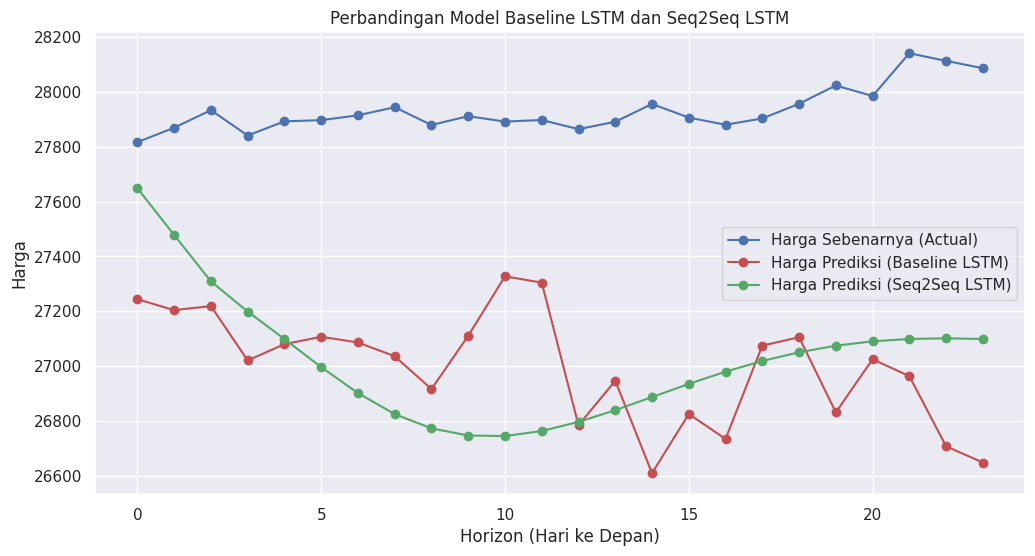

In [168]:
# Visualisasi Hasil
plt.figure(figsize=(12, 6))
plt.plot(actual_price, 'bo-', label='Harga Sebenarnya (Actual)')
plt.plot(predicted_price_baseline_lstm, 'ro-', label='Harga Prediksi (Baseline LSTM)')
plt.plot(predicted_price_seq2seqlstm, 'go-', label='Harga Prediksi (Seq2Seq LSTM)')
plt.title('Perbandingan Model Baseline LSTM dan Seq2Seq LSTM')
plt.ylabel('Harga')
plt.xlabel('Horizon (Hari ke Depan)')
plt.legend()
plt.grid(True)
plt.show()

# Summary

* Loss model baseline LSTM : 0.009503547102212906
* Loss model Seq2Seq LSTM : 0.014022002927958965
* The baseline LSTM model outperforms the Seq2Seq LSTM model. This is because the transformer architecture requires a large amount of data to achieve optimal results, as seen in the significant difference in loss values. In addition, in the visualization above, the Seq2Seq LSTM model tends to be more convergent and less susceptible to noise/bias. Conversely, the baseline LSTM model is very sensitive to noise when there is a spike in actual data. 
The final conclusion is to use the baseline LSTM model if you have limited data and use the Seq2Seq LSTM model if you have a large scale, as each method has its own advantages and disadvantages.